In [6]:
# -*- coding: utf-8 -*-
"""
STRICT NJ* (Criscuolo & Gascuel, BMC Bioinformatics 2008) for INCOMPLETE distance matrices.

Key correctness fixes vs many common “NJ* reimplementations”
----------------------------------------------------------
1) Pair selection criterion (6) is implemented as the normalized Q' form derived from Eq.(3):
      Q_xy   = R_x + R_y - (r-2) d_xy
      Q'_xy  = Q_xy / (r-2) = (R_x + R_y)/(r-2) - d_xy
   For incomplete matrices, the normalization is (|S_xy|-2) with S_xy = { i : d_xi and d_yi are known }.
   We thus score each eligible pair by:
      score6(x,y) = ( sum_{i in S_xy}(d_xi + d_yi) )/(|S_xy|-2) - d_xy
   and MAXIMIZE score6. (This is exactly consistent with the paper’s “maximize Q” convention.)

2) The ADDTREE-style tie-break statistics (Eqs.7–11) are applied lexicographically on the top-s pairs:
      (Eq.9)  Nbar = Ntilde / |C_xy|
      (Eq.8)  |C_xy| = number of quartets (i,j) that contribute at least one H-term
      (Eq.10) M* = |Miss(x) Δ Miss(y)| (symmetric difference)
      (Eq.11) N' = sum of positive margins (continuous version)
   Finally score6 is used as a last deterministic tie-break.

3) STRICT means:
   - No “bridge injection”, no forced completion.
   - If NJ* becomes undefined for a replicate, the run is reported as FAIL and continues.

Missing entries are encoded as -1.0 in input matrices.
Observed entries are preserved exactly in the completed matrix (only missing are filled).
"""

import os, time, warnings
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Optional

warnings.filterwarnings("ignore", category=UserWarning)

MISSING_VAL = -1.0
S_TOP = 15                 # paper default for top-s filtering
PRESERVE_OBSERVED = True   # keep observed distances unchanged in completed matrix

# ============================================================
# Loading / symmetry / minimal sanitize
# ============================================================
def load_matrix_with_candidates(cands: List[str]) -> Tuple[np.ndarray, str]:
    tried = []
    for p in cands:
        tried.append(p)
        if os.path.exists(p):
            M = np.loadtxt(p)
            # common “mtDNA in 10^-3” scale guard
            if np.nanmax(M) > 500:
                M = M / 1000.0
            return M, p
    raise FileNotFoundError(f"File not found. Tried: {tried}")

def symmetrize_full(D: np.ndarray) -> np.ndarray:
    D = 0.5 * (D + D.T)
    np.fill_diagonal(D, 0.0)
    return D

def symmetrize_with_missing(D: np.ndarray, tol: float = 1e-12) -> np.ndarray:
    """
    Enforce symmetry when missing is encoded by MISSING_VAL.
    If both sides are present but slightly different, average them (rare; usually already symmetric).
    """
    D = D.copy().astype(float)
    n = D.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            a, b = D[i, j], D[j, i]
            a_ok = (a >= 0.0)
            b_ok = (b >= 0.0)
            if a_ok and b_ok:
                v = 0.5 * (a + b) if abs(a - b) > tol else a
            elif a_ok:
                v = a
            elif b_ok:
                v = b
            else:
                v = MISSING_VAL
            D[i, j] = D[j, i] = v
    np.fill_diagonal(D, 0.0)
    return D

def sanitize_full_matrix(D: np.ndarray, name: str = "D") -> np.ndarray:
    """Minimal sanitize for a FULL matrix: finite, symmetric, nonnegative, zero diagonal."""
    M = np.array(D, dtype=float)
    if not np.isfinite(M).all():
        raise ValueError(f"{name} has non-finite entries.")
    M = 0.5 * (M + M.T)
    np.fill_diagonal(M, 0.0)
    M = np.maximum(M, 0.0)
    return M

def sanitize_completed_matrix(D: np.ndarray, obs_mask: Optional[np.ndarray] = None, D_obs: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Minimal sanitize for COMPLETED matrix without accidentally changing observed entries.
    If obs_mask and D_obs are provided, re-impose observed entries after sanitization.
    """
    M = np.array(D, dtype=float)
    if not np.isfinite(M).all():
        raise ValueError("Completed matrix has non-finite entries.")
    M = 0.5 * (M + M.T)
    np.fill_diagonal(M, 0.0)
    M = np.maximum(M, 0.0)

    if obs_mask is not None and D_obs is not None:
        M[obs_mask] = D_obs[obs_mask]
        M = 0.5 * (M + M.T)
        np.fill_diagonal(M, 0.0)

    return M

# ============================================================
# Mask generation (EXACT 15)
# ============================================================
def simulate_missing(D_full: np.ndarray, frac_missing: float, rng: np.random.RandomState):
    n = D_full.shape[0]
    lower = np.tril(np.ones((n, n), dtype=bool), k=-1)
    I, J = np.where(lower)
    m = len(I)
    drop = int(round(frac_missing * m))

    keep = np.ones(m, dtype=bool)
    if drop > 0:
        keep[rng.choice(m, size=drop, replace=False)] = False

    D_inc = D_full.copy().astype(float)
    for idx in range(m):
        i, j = I[idx], J[idx]
        if not keep[idx]:
            D_inc[i, j] = D_inc[j, i] = MISSING_VAL

    np.fill_diagonal(D_inc, 0.0)
    D_inc = symmetrize_with_missing(D_inc)

    obs_mask = (D_inc >= 0.0)
    np.fill_diagonal(obs_mask, True)
    return D_inc, obs_mask

# ============================================================
# RMSE helpers
# ============================================================
def rmse_all_pairs_lt(A: np.ndarray, B: np.ndarray) -> float:
    n = A.shape[0]
    i_lt, j_lt = np.tril_indices(n, k=-1)
    diff = (A - B)[i_lt, j_lt]
    return float(np.sqrt(np.mean(diff * diff)))

def rmse_missing_only_lt(A: np.ndarray, B: np.ndarray, obs_mask: np.ndarray) -> float:
    n = A.shape[0]
    lt = np.tril(np.ones((n, n), dtype=bool), k=-1)
    miss_lt = lt & (~obs_mask)
    if not np.any(miss_lt):
        return float("nan")
    diff = (A - B)[miss_lt]
    return float(np.sqrt(np.mean(diff * diff)))

# ============================================================
# Tree utilities (tree => unique paths => DFS distances)
# ============================================================
def _add_edge(adj: Dict[str, List[Tuple[str, float]]], a: str, b: str, w: float):
    w = float(w)
    if not np.isfinite(w) or w < 0.0:
        w = 0.0
    adj.setdefault(a, []).append((b, w))
    adj.setdefault(b, []).append((a, w))

def patristic_matrix_tree(adj: Dict[str, List[Tuple[str, float]]], leaf_names: List[str]) -> np.ndarray:
    leaves = leaf_names[:]
    idx = {nm: i for i, nm in enumerate(leaves)}
    n = len(leaves)
    Dp = np.zeros((n, n), dtype=float)

    for s in leaves:
        dist = {s: 0.0}
        stack = [(s, None)]
        while stack:
            u, parent = stack.pop()
            du = dist[u]
            for v, w in adj.get(u, []):
                if v == parent:
                    continue
                dist[v] = du + float(w)
                stack.append((v, u))

        si = idx[s]
        for t in leaves:
            Dp[si, idx[t]] = float(dist.get(t, np.inf))

    if not np.isfinite(Dp).all():
        raise RuntimeError("Patristic computation produced non-finite distances (tree disconnected?).")

    Dp = 0.5 * (Dp + Dp.T)
    np.fill_diagonal(Dp, 0.0)
    Dp = np.maximum(Dp, 0.0)
    return Dp

# ============================================================
# STRICT NJ* core (Criscuolo & Gascuel 2008)
# ============================================================
def _to_nan(D_in: np.ndarray) -> np.ndarray:
    D = D_in.astype(float).copy()
    D[D < 0.0] = np.nan
    np.fill_diagonal(D, 0.0)
    return D

def _count_components_known_graph(Dnan: np.ndarray) -> int:
    """Connected components of the graph whose edges are finite off-diagonal distances."""
    n = Dnan.shape[0]
    fin = np.isfinite(Dnan)
    adj = [[] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            if fin[i, j]:
                adj[i].append(j)
                adj[j].append(i)
    seen = [False] * n
    comps = 0
    for s in range(n):
        if seen[s]:
            continue
        comps += 1
        stack = [s]
        seen[s] = True
        while stack:
            u = stack.pop()
            for v in adj[u]:
                if not seen[v]:
                    seen[v] = True
                    stack.append(v)
    return comps

def _support_set_S(D: np.ndarray, x: int, y: int) -> np.ndarray:
    """S_xy = { i : d_xi and d_yi are known }. Assumes D is NaN for missing."""
    ok = np.isfinite(D[x, :]) & np.isfinite(D[y, :])
    return np.where(ok)[0]

def _criterion6_top_pairs(D: np.ndarray, s_top: int) -> List[Tuple[int, int, float]]:
    """
    Criterion (6): score6(x,y) = (sum_{i in S_xy}(d_xi + d_yi))/(|S_xy|-2) - d_xy
    Return top-s pairs (x<y) by descending score6.
    """
    r = D.shape[0]
    F = np.isfinite(D)
    # keep diagonal finite as True (it is 0.0)
    A = np.where(F, D, 0.0)

    Ff = F.astype(np.float64)
    Fi = F.astype(np.int32)

    # C_xy = |S_xy|
    C = Fi @ Fi.T  # int counts
    m = C - 2      # normalization

    # sum_x(x,y) = sum_{i : F[x,i]=1 and F[y,i]=1} D[x,i]
    sum_x = A @ Ff.T
    Rxy = sum_x + sum_x.T  # sum over S of (d_xi + d_yi)

    score = np.full((r, r), -np.inf, dtype=float)
    valid = np.isfinite(D) & (m >= 1)
    np.fill_diagonal(valid, False)
    score[valid] = (Rxy[valid] / m[valid]) - D[valid]

    iu, ju = np.triu_indices(r, k=1)
    vals = score[iu, ju]
    mask = np.isfinite(vals)
    if not np.any(mask):
        return []

    iu = iu[mask]
    ju = ju[mask]
    vals = vals[mask]

    if vals.size > s_top:
        # select top s_top by partial selection
        keep = np.argpartition(vals, -s_top)[-s_top:]
        iu, ju, vals = iu[keep], ju[keep], vals[keep]

    order = np.argsort(vals)[::-1]
    return [(int(iu[k]), int(ju[k]), float(vals[k])) for k in order]

def _nstar_stats_7_to_11(D: np.ndarray, x: int, y: int) -> Tuple[float, int, int, float]:
    """
    Compute tie-break stats (Eqs.7–11), used lexicographically:
      1) Nbar  = Ntilde / |C_xy|         (Eq.9)
      2) C_cnt = |C_xy|                  (Eq.8)
      3) Mstar = |Miss(x) Δ Miss(y)|     (Eq.10)
      4) Nprime = sum positive margins   (Eq.11)
    where each quartet (i,j) contributes if d_ij is known and at least one H-term is computable.
    """
    r = D.shape[0]
    dxy = D[x, y]
    if not np.isfinite(dxy):
        return -np.inf, 0, 0, -np.inf

    # Miss(z) = { i != z : d_iz is missing }
    miss_x = set(np.where(~np.isfinite(D[:, x]))[0].tolist())
    miss_y = set(np.where(~np.isfinite(D[:, y]))[0].tolist())
    miss_x.discard(x)
    miss_y.discard(y)
    Mstar = int(len(miss_x.symmetric_difference(miss_y)))

    Ntilde = 0.0
    C_cnt = 0
    Nprime = 0.0

    for i in range(r):
        if i == x or i == y:
            continue
        for j in range(i + 1, r):
            if j == x or j == y:
                continue

            dij = D[i, j]
            if not np.isfinite(dij):
                continue

            t1_avail = np.isfinite(D[x, i]) and np.isfinite(D[y, j])
            t2_avail = np.isfinite(D[x, j]) and np.isfinite(D[y, i])
            if not (t1_avail or t2_avail):
                continue

            # This quartet contributes (Eq.8)
            C_cnt += 1

            if t1_avail:
                t1 = D[x, i] + D[y, j] - dxy - dij
                if t1 >= 0.0:
                    Ntilde += 1.0
                if t1 > 0.0:
                    Nprime += float(t1)

            if t2_avail:
                t2 = D[x, j] + D[y, i] - dxy - dij
                if t2 >= 0.0:
                    Ntilde += 1.0
                if t2 > 0.0:
                    Nprime += float(t2)

    Nbar = float(Ntilde / C_cnt) if C_cnt > 0 else 0.0
    if C_cnt == 0:
        Nprime = 0.0

    return float(Nbar), int(C_cnt), int(Mstar), float(Nprime)

def _estimate_branch_lengths_eq12(D: np.ndarray, x: int, y: int, S: np.ndarray) -> Tuple[float, float]:
    """
    Eq. (12) for NJ* with equal weights:
      l_x = d_xy/2 + w * sum_{i in S\{x,y}} (d_xi - d_yi),  w = 1/(2(|S|-2))
      l_y = d_xy - l_x
    """
    dxy = float(D[x, y])
    m = int(len(S) - 2)
    if m <= 0:
        raise RuntimeError("Eq(12) undefined: |S_xy|-2 <= 0.")

    others = [i for i in S.tolist() if i != x and i != y]
    diff_sum = float(np.sum(D[x, others] - D[y, others])) if len(others) > 0 else 0.0
    w = 1.0 / (2.0 * m)

    lx = 0.5 * dxy + w * diff_sum
    ly = dxy - lx

    # Practical safeguard: nonnegative
    if lx < 0.0:
        lx = 0.0
        ly = dxy
    if ly < 0.0:
        ly = 0.0
        lx = dxy

    return float(lx), float(ly)

def _reduce_matrix_eq13(D: np.ndarray, x: int, y: int, lx: float, ly: float) -> np.ndarray:
    """
    Eq. (13), lambda = 1/2:
      if both d_xi and d_yi present: d_ui = 0.5*((d_xi - lx) + (d_yi - ly))
      if only one present:          d_ui = d_xi - lx  OR  d_yi - ly
      if none present:              missing (NaN)
    """
    r = D.shape[0]
    keep = [k for k in range(r) if k not in (x, y)]
    Dk = D[np.ix_(keep, keep)].copy()

    du = np.full((len(keep),), np.nan, dtype=float)
    for a_idx, i in enumerate(keep):
        dxi = D[x, i]
        dyi = D[y, i]
        if np.isfinite(dxi) and np.isfinite(dyi):
            val = 0.5 * ((dxi - lx) + (dyi - ly))
            du[a_idx] = val
        elif np.isfinite(dxi):
            du[a_idx] = dxi - lx
        elif np.isfinite(dyi):
            du[a_idx] = dyi - ly
        else:
            du[a_idx] = np.nan

    du = np.where(np.isfinite(du), np.maximum(0.0, du), np.nan)

    r2 = len(keep) + 1
    Dnew = np.full((r2, r2), np.nan, dtype=float)
    Dnew[:len(keep), :len(keep)] = Dk
    Dnew[:len(keep), -1] = du
    Dnew[-1, :len(keep)] = du
    Dnew[-1, -1] = 0.0
    return Dnew

def nj_star_tree_strict(
    D_incomplete: np.ndarray,
    leaf_names: List[str],
    s_top: int = S_TOP
) -> Tuple[Optional[Dict[str, List[Tuple[str, float]]]], str, str]:
    """
    STRICT NJ* tree inference on incomplete matrix.
    Returns (adjacency_or_None, status, reason) with status in {"OK","FAIL"}.
    """
    D = _to_nan(symmetrize_with_missing(D_incomplete))
    nodes = leaf_names[:]

    # Early impossibility check: disconnected known-distance graph
    comps = _count_components_known_graph(D)
    if comps > 1:
        return None, "FAIL", f"Known-distance graph is disconnected ({comps} components)."

    adj: Dict[str, List[Tuple[str, float]]] = {nm: [] for nm in nodes}
    next_internal_id = 1

    while len(nodes) > 2:
        r = len(nodes)

        # 1) top-s using criterion (6)
        top_pairs = _criterion6_top_pairs(D, s_top)
        if not top_pairs:
            return None, "FAIL", f"No eligible pair at r={r}: need d_xy known and |S_xy|>=3."

        # 2) lexicographic tie-break on top-s (Eqs 9,8,10,11), then criterion6 last
        best = None
        best_key = None
        for x, y, sc6 in top_pairs:
            S = _support_set_S(D, x, y)
            if len(S) < 3:
                continue

            Nbar, C_cnt, Mstar, Nprime = _nstar_stats_7_to_11(D, x, y)
            key = (Nbar, C_cnt, Mstar, Nprime, sc6)

            if best_key is None or key > best_key:
                best_key = key
                best = (x, y, S)

        if best is None:
            return None, "FAIL", f"Top-s pairs existed but none had |S_xy|>=3 at r={r}."

        x, y, S = best
        nx, ny = nodes[x], nodes[y]

        # 3) branch lengths (Eq 12)
        try:
            lx, ly = _estimate_branch_lengths_eq12(D, x, y, S)
        except RuntimeError as e:
            return None, "FAIL", f"Eq(12) undefined at r={r} for ({nx},{ny}): {str(e)}"

        # 4) add internal node and edges
        u = f"U{next_internal_id}"
        next_internal_id += 1
        adj.setdefault(u, [])
        _add_edge(adj, u, nx, lx)
        _add_edge(adj, u, ny, ly)

        # 5) reduce matrix (Eq 13) and update node list
        D = _reduce_matrix_eq13(D, x, y, lx, ly)
        keep_idx = [k for k in range(r) if k not in (x, y)]
        nodes = [nodes[k] for k in keep_idx] + [u]

    # Termination r=2: connect last two nodes
    a, b = nodes[0], nodes[1]
    d = D[0, 1]
    if not np.isfinite(d):
        return None, "FAIL", "Reached r=2 but final distance is missing (cannot connect last two clusters)."
    _add_edge(adj, a, b, float(d))

    return adj, "OK", "OK"

# ============================================================
# Completion wrapper: NJ* tree -> patristic -> fill missing only
# ============================================================
def nj_star_complete_strict(
    D_inc: np.ndarray,
    obs_mask: np.ndarray,
    labels: List[str]
) -> Tuple[Optional[np.ndarray], str, str]:
    adj, status, reason = nj_star_tree_strict(D_inc, labels, s_top=S_TOP)
    if status != "OK":
        return None, status, reason

    D_pat = patristic_matrix_tree(adj, labels)

    # Fill missing only; preserve observed exactly
    Dm = symmetrize_with_missing(D_inc)  # observed >=0, missing = -1
    D_out = D_pat.copy()
    if PRESERVE_OBSERVED:
        D_out[obs_mask] = Dm[obs_mask]

    # final symmetry/diagonal guard (do not disturb observed after)
    D_out = sanitize_completed_matrix(D_out, obs_mask=obs_mask, D_obs=Dm)
    return D_out, "OK", "OK"

# ============================================================
# MAIN FLOW: run on ALL 15 masks (30/50/65 x 5 reps)
# ============================================================
D_orig, used_orig_path = load_matrix_with_candidates([
       "Result_NW_15x15.txt",
    "./Result_NW_15x15.txt",
    "/mnt/data/Result_NW_15x15.txt",
])

D0 = sanitize_full_matrix(symmetrize_full(D_orig), "D_orig")
n = D0.shape[0]
labels = [f"T{i+1}" for i in range(n)]

print("=== ORIGINAL MATRIX (reference) ===")
print(f"Original matrix file: {used_orig_path}")
print(f"n = {n}")
print()

MISSING_FRACS = (0.30, 0.50, 0.65, 0.85, 0.90)
REPS = 5
BASE_SEED = 55

# Generate and save masked matrices
masked_registry = []
for frac in MISSING_FRACS:
    pct = int(round(100 * frac))
    for rep in range(1, REPS + 1):
        # distinct seeds across missingness levels and replicates
        seed = BASE_SEED + (rep - 1)
        rng = np.random.RandomState(seed)
        D_inc, obs_mask = simulate_missing(D0, frac, rng)
        masked_registry.append({"frac": frac, "pct": pct, "rep": rep, "D_inc": D_inc, "obs_mask": obs_mask})

masked_dir = "njstar_strict_missing_matrices"
os.makedirs(masked_dir, exist_ok=True)
for rec in masked_registry:
    fn = f"missing_p{rec['pct']}_rep{rec['rep']}.csv"
    pd.DataFrame(rec["D_inc"], index=labels, columns=labels).to_csv(os.path.join(masked_dir, fn))

print("=== Running STRICT NJ* on all 15 masks ===")
results = []
completed_dir = "njstar_strict_completed_matrices"
os.makedirs(completed_dir, exist_ok=True)

for rec in masked_registry:
    pct = rec["pct"]
    rep = rec["rep"]
    D_inc = rec["D_inc"]
    Mobs = rec["obs_mask"]

    print(f"  Processing {pct}% missing, replicate {rep}...")

    t0 = time.perf_counter()
    D_completed, status, reason = nj_star_complete_strict(D_inc, Mobs, labels)
    runtime_sec = time.perf_counter() - t0

    if status != "OK":
        print(f"    -> FAIL: {reason}")
        results.append({
            "pct_missing": pct,
            "replicate": rep,
            "status": "FAIL",
            "reason": reason,
            "RMSE_all_pairs": np.nan,
            "RMSE_missing_only": np.nan,
            "runtime_seconds": runtime_sec,
            "completed_file": ""
        })
        continue

    Dm = symmetrize_with_missing(D_inc)
    D_san = sanitize_completed_matrix(D_completed, obs_mask=Mobs, D_obs=Dm)

    rmse_all = rmse_all_pairs_lt(D_san, D0)
    rmse_holdout = rmse_missing_only_lt(D_san, D0, Mobs)

    out_fn = f"NJstar_STRICT_completed_p{pct}_rep{rep}.csv"
    pd.DataFrame(D_san, index=labels, columns=labels).to_csv(os.path.join(completed_dir, out_fn))

    results.append({
        "pct_missing": pct,
        "replicate": rep,
        "status": "OK",
        "reason": "OK",
        "RMSE_all_pairs": rmse_all,
        "RMSE_missing_only": rmse_holdout,
        "runtime_seconds": runtime_sec,
        "completed_file": out_fn
    })

results_df = pd.DataFrame(results)
results_df.to_csv("njstar_strict_all_masks_detailed.csv", index=False)

print("\n=== NJ* STRICT results (all 15 masks) ===")
try:
    from IPython.display import display
    display(results_df)
except Exception:
    print(results_df.to_string(index=False))

# Summary (mean ± std over successful reps only)
def mean_std(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return float("nan"), float("nan")
    m = float(np.mean(x))
    s = float(np.std(x, ddof=1)) if x.size > 1 else 0.0
    return m, s

summary_rows = []
for frac in MISSING_FRACS:
    pct = int(round(100 * frac))
    sub = results_df[(results_df["pct_missing"] == pct) & (results_df["status"] == "OK")]

    rmse_m, rmse_s = mean_std(sub["RMSE_all_pairs"].values)
    hold_m, hold_s = mean_std(sub["RMSE_missing_only"].values)
    rt_m, rt_s = mean_std(sub["runtime_seconds"].values)

    fail_count = int((results_df["pct_missing"] == pct).sum() - len(sub))

    summary_rows.append({
        "% Missing": f"{pct}%",
        "OK_count": int(len(sub)),
        "FAIL_count": fail_count,
        "RMSE_all_mean": rmse_m, "RMSE_all_std": rmse_s,
        "RMSE_holdout_mean": hold_m, "RMSE_holdout_std": hold_s,
        "runtime_mean_s": rt_m, "runtime_std_s": rt_s
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("njstar_strict_summary_numeric.csv", index=False)

print("\n=== NJ* STRICT summary (successful reps only) ===")
try:
    from IPython.display import display
    display(summary_df)
except Exception:
    print(summary_df.to_string(index=False))

print("\n=== DONE ===")
print(f"Masked matrices:    {masked_dir}/")
print(f"Completed matrices: {completed_dir}/")
print("Detailed results:   njstar_strict_all_masks_detailed.csv")
print("Summary:            njstar_strict_summary_numeric.csv")


=== ORIGINAL MATRIX (reference) ===
Original matrix file: Result_NW_15x15.txt
n = 15

=== Running STRICT NJ* on all 15 masks ===
  Processing 30% missing, replicate 1...
  Processing 30% missing, replicate 2...
  Processing 30% missing, replicate 3...
  Processing 30% missing, replicate 4...
  Processing 30% missing, replicate 5...
  Processing 50% missing, replicate 1...
  Processing 50% missing, replicate 2...
  Processing 50% missing, replicate 3...
    -> FAIL: No eligible pair at r=3: need d_xy known and |S_xy|>=3.
  Processing 50% missing, replicate 4...
  Processing 50% missing, replicate 5...
  Processing 65% missing, replicate 1...
  Processing 65% missing, replicate 2...
    -> FAIL: No eligible pair at r=4: need d_xy known and |S_xy|>=3.
  Processing 65% missing, replicate 3...
    -> FAIL: No eligible pair at r=3: need d_xy known and |S_xy|>=3.
  Processing 65% missing, replicate 4...
  Processing 65% missing, replicate 5...
    -> FAIL: No eligible pair at r=4: need d_xy k

,pct_missing,replicate,status,reason,RMSE_all_pairs,RMSE_missing_only,runtime_seconds,completed_file
0,30,1,OK,OK,0.012210,0.022118,0.009257,NJstar_STRICT_completed_p30_rep1.csv
1,30,2,OK,OK,0.016705,0.030260,0.009028,NJstar_STRICT_completed_p30_rep2.csv
2,30,3,OK,OK,0.003424,0.006203,0.008552,NJstar_STRICT_completed_p30_rep3.csv
3,30,4,OK,OK,0.002792,0.005057,0.009075,NJstar_STRICT_completed_p30_rep4.csv
4,30,5,OK,OK,0.016197,0.029339,0.008757,NJstar_STRICT_completed_p30_rep5.csv
5,50,1,OK,OK,0.027402,0.038938,0.006904,NJstar_STRICT_completed_p50_rep1.csv
6,50,2,OK,OK,0.018471,0.026247,0.007137,NJstar_STRICT_completed_p50_rep2.csv
7,50,3,FAIL,No eligible pair at r=3: need d_xy known and |...,NaN,NaN,0.006129,
8,50,4,OK,OK,0.014792,0.021019,0.013303,NJstar_STRICT_completed_p50_rep4.csv
9,50,5,OK,OK,0.033480,0.047575,0.007101,NJstar_STRICT_completed_p50_rep5.csv



=== NJ* STRICT summary (successful reps only) ===


,% Missing,OK_count,FAIL_count,RMSE_all_mean,RMSE_all_std,RMSE_holdout_mean,RMSE_holdout_std,runtime_mean_s,runtime_std_s
0,30%,5,0,0.010266,0.006766,0.018595,0.012255,0.008934,0.000278
1,50%,4,1,0.023536,0.008484,0.033445,0.012056,0.008611,0.003129
2,65%,2,3,0.027975,0.000861,0.034762,0.001070,0.005856,0.000084
3,85%,0,5,NaN,NaN,NaN,NaN,NaN,NaN
4,90%,0,5,NaN,NaN,NaN,NaN,NaN,NaN



=== DONE ===
Masked matrices:    njstar_strict_missing_matrices/
Completed matrices: njstar_strict_completed_matrices/
Detailed results:   njstar_strict_all_masks_detailed.csv
Summary:            njstar_strict_summary_numeric.csv


Loading original matrix...
  Original matrix loaded: Result_NW_15x15.txt
  Original matrix shape: (15, 15)

Processing STRICT NJ* completed matrices -> NJ trees for 30% missing (rep1..5)

----------------------------------------------------------------------
p30 | replicate 1: njstar_strict_completed_matrices/NJstar_STRICT_completed_p30_rep1.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p30_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


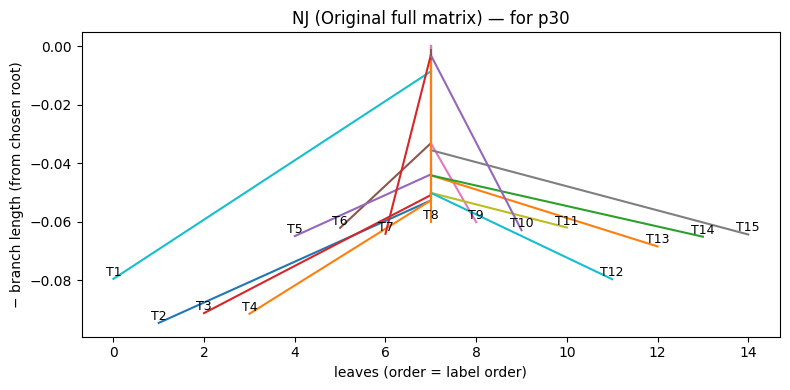

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


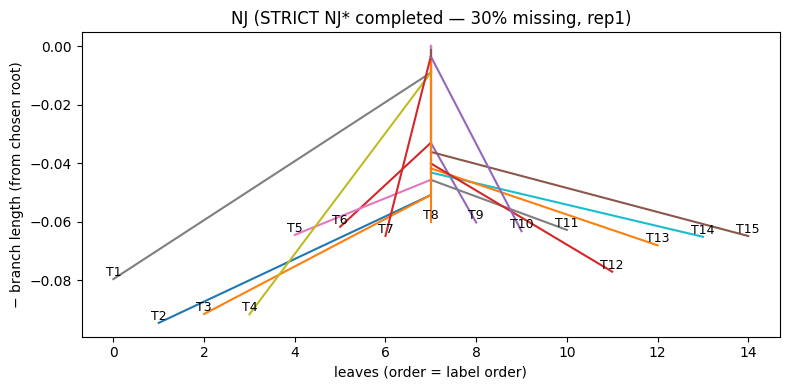

    Saved: tree_NJstar_rep1.png, tree_NJstar_rep1.newick

  Summary p30 rep1:
    RF_norm=0.416667 | pat_RMSE=0.012168 | mat_RMSE=0.012210

----------------------------------------------------------------------
p30 | replicate 2: njstar_strict_completed_matrices/NJstar_STRICT_completed_p30_rep2.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p30_rep2.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


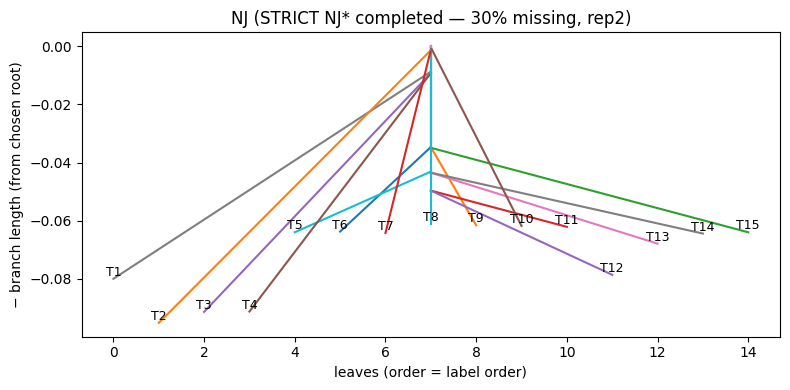

    Saved: tree_NJstar_rep2.png, tree_NJstar_rep2.newick

  Summary p30 rep2:
    RF_norm=0.500000 | pat_RMSE=0.016722 | mat_RMSE=0.016701

----------------------------------------------------------------------
p30 | replicate 3: njstar_strict_completed_matrices/NJstar_STRICT_completed_p30_rep3.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p30_rep3.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


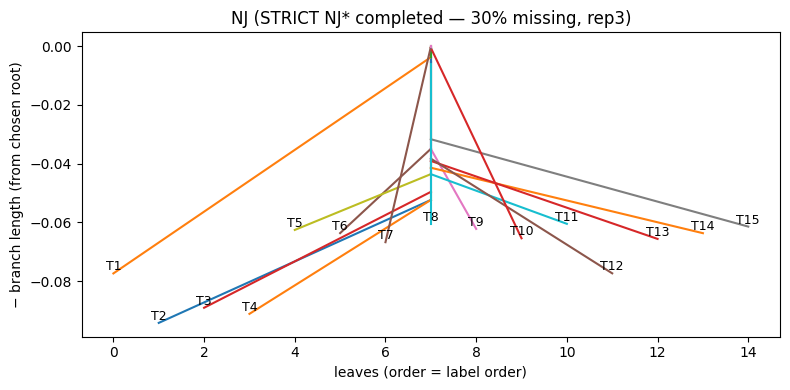

    Saved: tree_NJstar_rep3.png, tree_NJstar_rep3.newick

  Summary p30 rep3:
    RF_norm=0.416667 | pat_RMSE=0.003460 | mat_RMSE=0.003424

----------------------------------------------------------------------
p30 | replicate 4: njstar_strict_completed_matrices/NJstar_STRICT_completed_p30_rep4.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p30_rep4.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


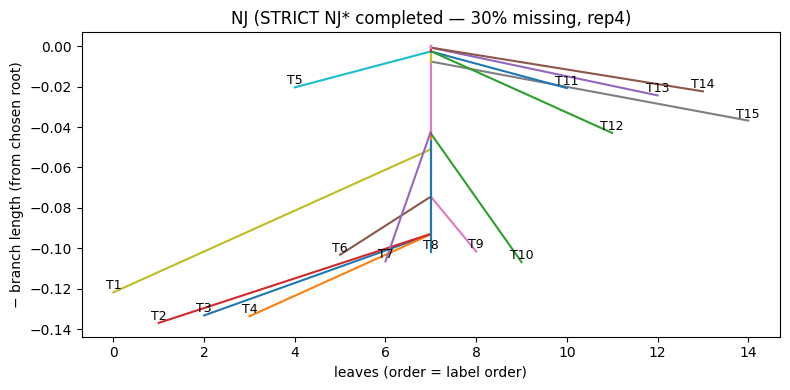

    Saved: tree_NJstar_rep4.png, tree_NJstar_rep4.newick

  Summary p30 rep4:
    RF_norm=0.583333 | pat_RMSE=0.002783 | mat_RMSE=0.002792

----------------------------------------------------------------------
p30 | replicate 5: njstar_strict_completed_matrices/NJstar_STRICT_completed_p30_rep5.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p30_rep5.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


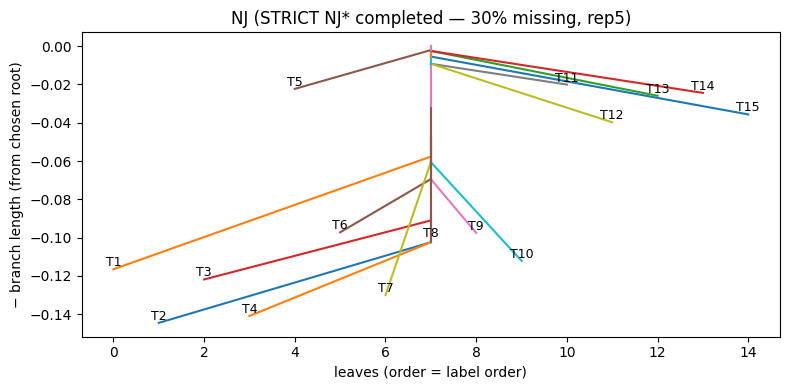

    Saved: tree_NJstar_rep5.png, tree_NJstar_rep5.newick

  Summary p30 rep5:
    RF_norm=0.333333 | pat_RMSE=0.014391 | mat_RMSE=0.016197

Processing STRICT NJ* completed matrices -> NJ trees for 50% missing (rep1..5)

----------------------------------------------------------------------
p50 | replicate 1: njstar_strict_completed_matrices/NJstar_STRICT_completed_p50_rep1.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p50_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


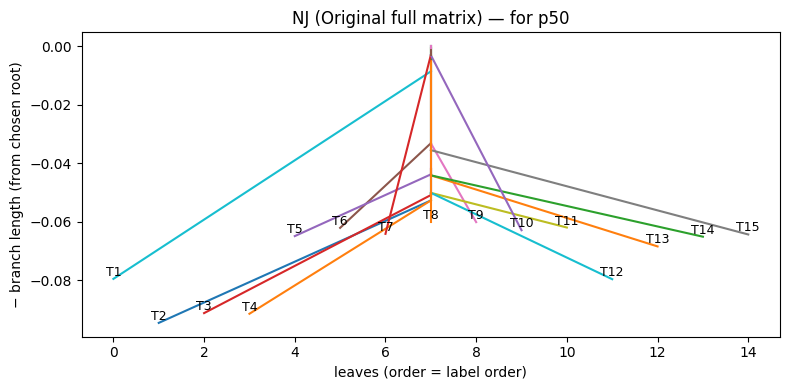

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


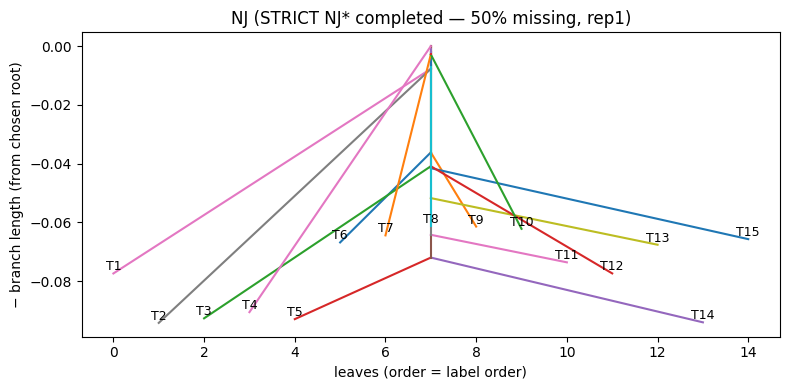

    Saved: tree_NJstar_rep1.png, tree_NJstar_rep1.newick

  Summary p50 rep1:
    RF_norm=0.750000 | pat_RMSE=0.026862 | mat_RMSE=0.027401

----------------------------------------------------------------------
p50 | replicate 2: njstar_strict_completed_matrices/NJstar_STRICT_completed_p50_rep2.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p50_rep2.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


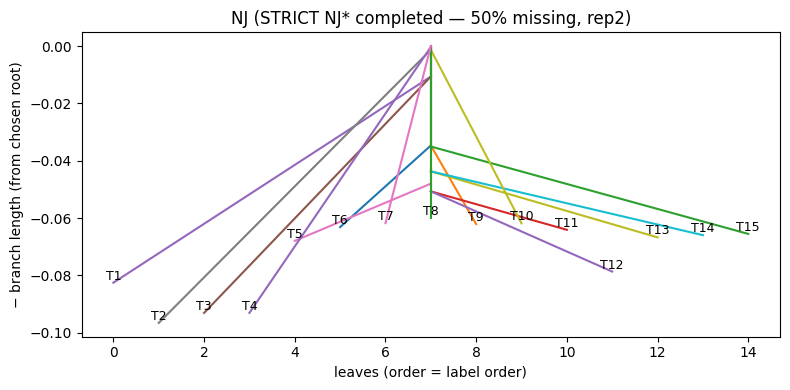

    Saved: tree_NJstar_rep2.png, tree_NJstar_rep2.newick

  Summary p50 rep2:
    RF_norm=0.500000 | pat_RMSE=0.018393 | mat_RMSE=0.018471

----------------------------------------------------------------------
p50 | replicate 3: njstar_strict_completed_matrices/NJstar_STRICT_completed_p50_rep3.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p50_rep3.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


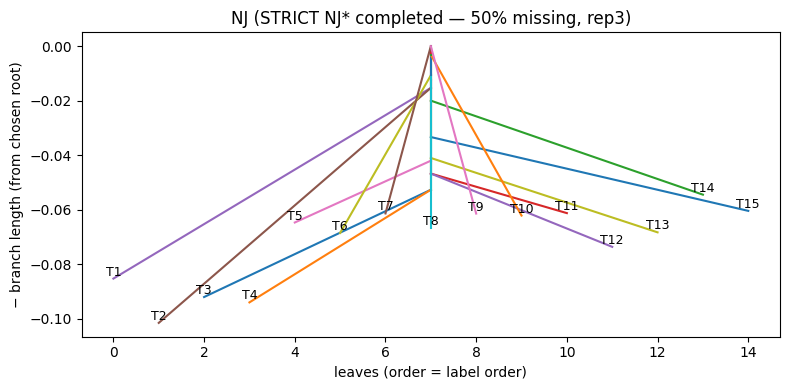

    Saved: tree_NJstar_rep3.png, tree_NJstar_rep3.newick

  Summary p50 rep3:
    RF_norm=0.666667 | pat_RMSE=0.016538 | mat_RMSE=0.018336

----------------------------------------------------------------------
p50 | replicate 4: njstar_strict_completed_matrices/NJstar_STRICT_completed_p50_rep4.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p50_rep4.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


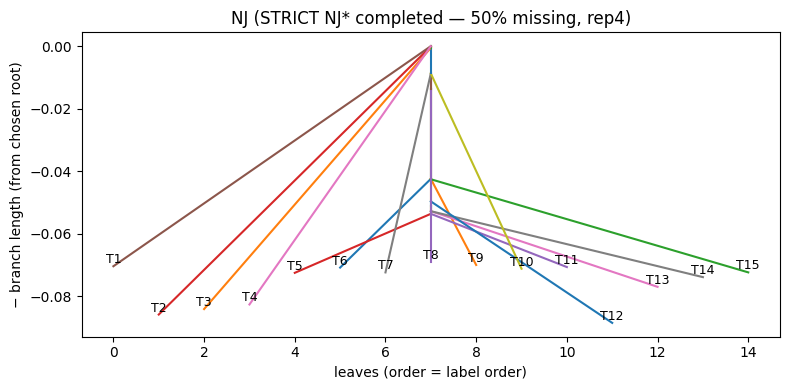

    Saved: tree_NJstar_rep4.png, tree_NJstar_rep4.newick

  Summary p50 rep4:
    RF_norm=0.416667 | pat_RMSE=0.014771 | mat_RMSE=0.014792

----------------------------------------------------------------------
p50 | replicate 5: njstar_strict_completed_matrices/NJstar_STRICT_completed_p50_rep5.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p50_rep5.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


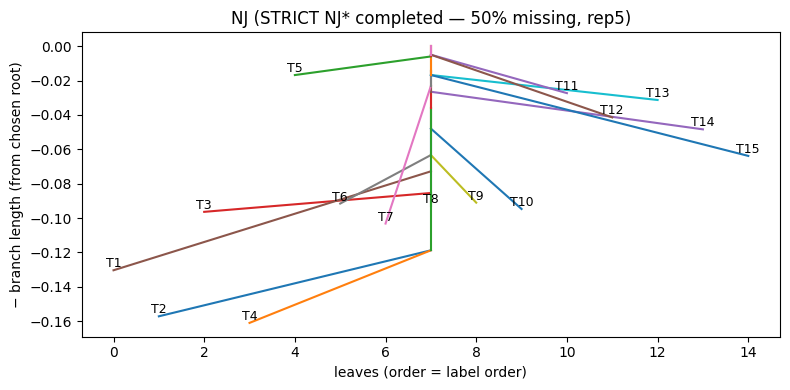

    Saved: tree_NJstar_rep5.png, tree_NJstar_rep5.newick

  Summary p50 rep5:
    RF_norm=0.500000 | pat_RMSE=0.033035 | mat_RMSE=0.033479

Processing STRICT NJ* completed matrices -> NJ trees for 65% missing (rep1..5)

----------------------------------------------------------------------
p65 | replicate 1: njstar_strict_completed_matrices/NJstar_STRICT_completed_p65_rep1.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p65_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


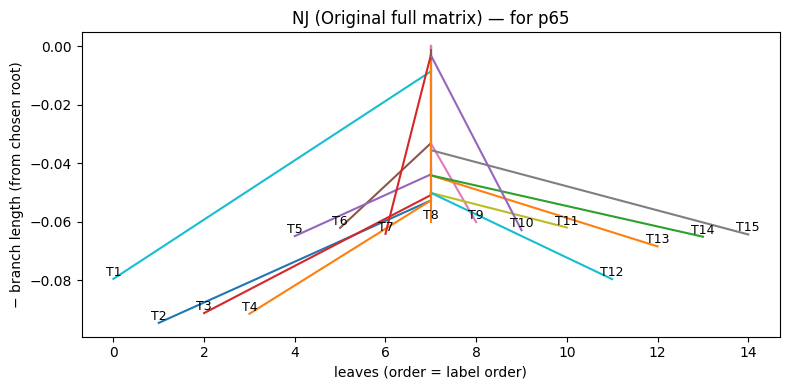

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


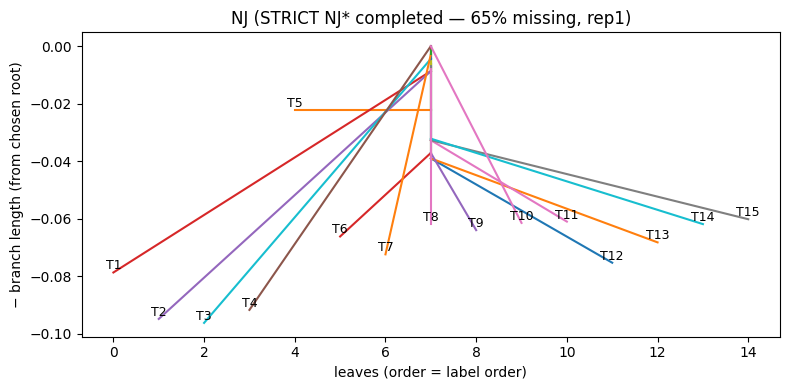

    Saved: tree_NJstar_rep1.png, tree_NJstar_rep1.newick

  Summary p65 rep1:
    RF_norm=0.750000 | pat_RMSE=0.027667 | mat_RMSE=0.028580

----------------------------------------------------------------------
p65 | replicate 2: njstar_strict_completed_matrices/NJstar_STRICT_completed_p65_rep2.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p65_rep2.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


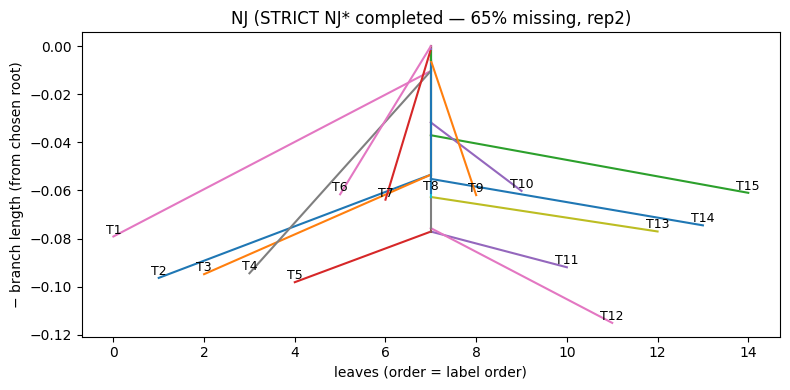

    Saved: tree_NJstar_rep2.png, tree_NJstar_rep2.newick

  Summary p65 rep2:
    RF_norm=0.666667 | pat_RMSE=0.025679 | mat_RMSE=0.026630

----------------------------------------------------------------------
p65 | replicate 3: njstar_strict_completed_matrices/NJstar_STRICT_completed_p65_rep3.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p65_rep3.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


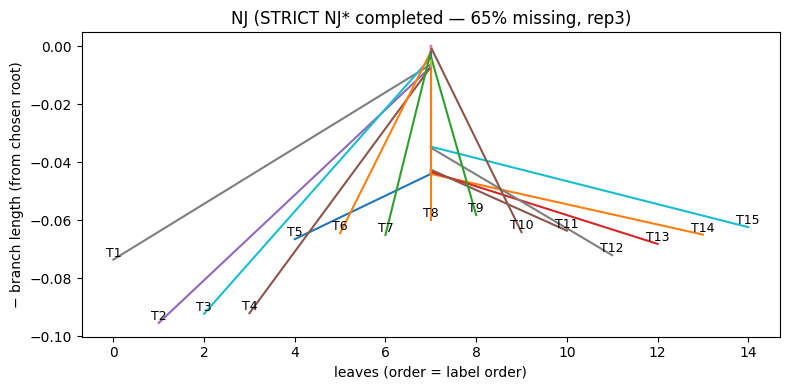

    Saved: tree_NJstar_rep3.png, tree_NJstar_rep3.newick

  Summary p65 rep3:
    RF_norm=0.666667 | pat_RMSE=0.017866 | mat_RMSE=0.018135

----------------------------------------------------------------------
p65 | replicate 4: njstar_strict_completed_matrices/NJstar_STRICT_completed_p65_rep4.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p65_rep4.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


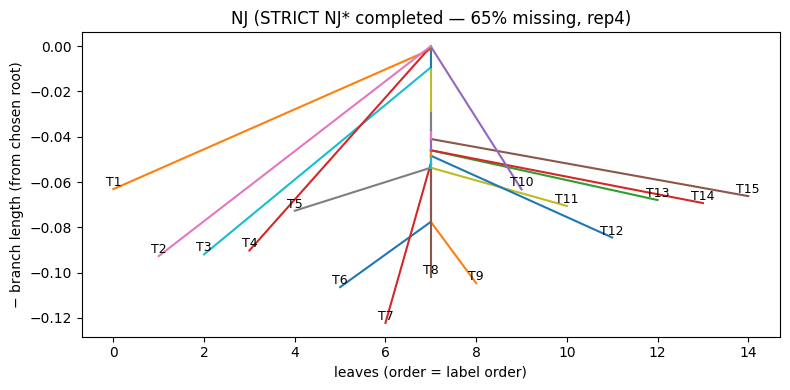

    Saved: tree_NJstar_rep4.png, tree_NJstar_rep4.newick

  Summary p65 rep4:
    RF_norm=0.666667 | pat_RMSE=0.026181 | mat_RMSE=0.027363

----------------------------------------------------------------------
p65 | replicate 5: njstar_strict_completed_matrices/NJstar_STRICT_completed_p65_rep5.csv
----------------------------------------------------------------------
  Loaded NJ* completed matrix: NJstar_STRICT_completed_p65_rep5.csv | shape=(15, 15)
  Building NJ tree for NJ* completed matrix...
    NJ* (completed) NJ tree built


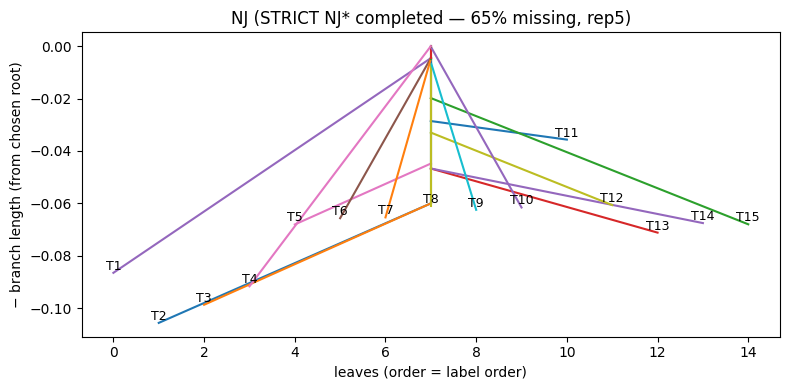

    Saved: tree_NJstar_rep5.png, tree_NJstar_rep5.newick

  Summary p65 rep5:
    RF_norm=0.750000 | pat_RMSE=0.021675 | mat_RMSE=0.023303

Processing STRICT NJ* completed matrices -> NJ trees for 85% missing (rep1..5)

----------------------------------------------------------------------
p85 | replicate 1: njstar_strict_completed_matrices/NJstar_STRICT_completed_p85_rep1.csv
----------------------------------------------------------------------

----------------------------------------------------------------------
p85 | replicate 2: njstar_strict_completed_matrices/NJstar_STRICT_completed_p85_rep2.csv
----------------------------------------------------------------------

----------------------------------------------------------------------
p85 | replicate 3: njstar_strict_completed_matrices/NJstar_STRICT_completed_p85_rep3.csv
----------------------------------------------------------------------

----------------------------------------------------------------------
p85 | replica

In [7]:
# Cell — PICTURES OF TREES (30/50/65/85/90% missing × 5 replicates) for STRICT NJ*
# NJ version + detailed benchmarks + mean ± SD by missingness + all-levels CSV
#
# Expected inputs (default):
#   njstar_strict_completed_matrices/NJstar_STRICT_completed_p{30,50,65,85,90}_rep{1..5}.csv
#
# Output:
#   trees_njstar_strict_nj_all15/
#     p30/ tree_Original.png, tree_NJstar_rep1.png ... tree_NJstar_rep5.png, *.newick
#     p50/ ...
#     p65/ ...
#     p85/ ...
#     p90/ ...
#     benchmark_tree_all15.csv
#     benchmark_matrix_all15.csv
#     benchmark_tree_by_missingness.csv
#     benchmark_matrix_by_missingness.csv
#     stats_tree_by_missingness.csv
#     stats_matrix_by_missingness.csv
#
# Notes:
# - "Matrix metrics" compare the COMPLETED NJ* matrix vs the ORIGINAL full matrix (upper-triangle vectors).
# - "Tree metrics" compare NJ trees built from those matrices (splits via unrooted splits on the undirected tree).
# - This cell does NOT re-run NJ*: it only reads the completed matrices you already produced.

import os
import warnings
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


# ============================================================
# I/O HELPERS
# ============================================================
def load_matrix_with_candidates(cands: List[str]) -> Tuple[np.ndarray, str]:
    for p in cands:
        if os.path.exists(p):
            M = np.loadtxt(p)
            # heuristic: if distances are in ~1000s, rescale to ~units
            if np.nanmax(M) > 500:
                M = M / 1000.0
            return M, p
    raise FileNotFoundError(f"File not found. Tried: {cands}")


def load_completed_csv(path_csv: str) -> Tuple[np.ndarray, List[str]]:
    if not os.path.exists(path_csv):
        raise FileNotFoundError(path_csv)
    df = pd.read_csv(path_csv, index_col=0)
    labels_cols = list(df.columns)
    labels_idx = list(df.index)
    # Prefer columns as labels; sanity-check consistency if possible
    if len(labels_cols) == len(labels_idx) and all(str(a) == str(b) for a, b in zip(labels_idx, labels_cols)):
        labels = labels_cols
    else:
        labels = labels_cols
    return df.values.astype(float), labels


# ============================================================
# SANITIZATION
# ============================================================
def _finite_fill(v, fallback: float = 1.0) -> float:
    v = np.asarray(v, dtype=float)
    vv = v[np.isfinite(v)]
    if vv.size > 0:
        return float(np.nanmedian(vv))
    return float(fallback)


def sanitize_distance_matrix(D: np.ndarray, name: str = "D", force_nonneg: bool = True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError(f"{name} must be a square matrix. Got shape {M.shape}.")

    n = M.shape[0]

    # remove negative off-diagonal (treat as missing)
    neg = (M < 0)
    np.fill_diagonal(neg, False)
    M[neg] = np.nan

    off = ~np.eye(n, dtype=bool)
    med = _finite_fill(M[off], fallback=1.0)

    # fill NaN/inf with median
    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)

    # winsorize extreme upper tail on off-diagonal
    try:
        q = np.quantile(M[off], 0.995)
    except Exception:
        q = np.nan
    if np.isfinite(q) and q > 0:
        M[off] = np.minimum(M[off], q)

    # symmetrize + nonneg + zero diagonal
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)

    if not np.isfinite(M).all():
        raise ValueError(f"{name} has non-finite entries after sanitize.")
    return M


# ============================================================
# NJ TREE OBJECT
# ============================================================
@dataclass
class NJTree:
    newick: str
    patristic: np.ndarray            # n x n leaf-to-leaf path lengths
    splits: Set[frozenset]           # unrooted splits (bipartitions) as leaf-label sets
    adj: Dict[int, Dict[int, float]] # weighted undirected adjacency
    root: int                        # chosen root node id for Newick/drawing


# ============================================================
# NJ (Neighbor-Joining) + splits/patristic
# ============================================================
def neighbor_joining_nonneg(D_full: np.ndarray, labels: List[str], eps: float = 1e-12) -> NJTree:
    D = sanitize_distance_matrix(D_full, "NJ_input", force_nonneg=True)
    n = len(labels)
    if D.shape != (n, n):
        raise ValueError(f"Distance matrix shape {D.shape} does not match number of labels n={n}.")

    # adjacency for final tree
    adj: Dict[int, Dict[int, float]] = {}

    def add_edge(u: int, v: int, w: float):
        w = float(w)
        if not np.isfinite(w):
            w = 1e-9
        w = max(w, 1e-9)  # keep strictly positive for drawing/path lengths
        adj.setdefault(u, {})
        adj.setdefault(v, {})
        adj[u][v] = w
        adj[v][u] = w

    # Special small-n cases
    if n == 1:
        root = 0
        newick = f"{labels[0]};"
        P = np.zeros((1, 1), dtype=float)
        splits = set()
        return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)

    if n == 2:
        root = 2
        d01 = float(D[0, 1])
        add_edge(root, 0, 0.5 * d01)
        add_edge(root, 1, 0.5 * d01)
        newick = f"({labels[0]}:{0.5*d01:.6f},{labels[1]}:{0.5*d01:.6f});"
        P = np.array([[0.0, d01], [d01, 0.0]], dtype=float)
        splits = set()
        return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)

    next_id = n
    active = list(range(n))

    dist: Dict[Tuple[int, int], float] = {}
    for i in range(n):
        for j in range(i + 1, n):
            dist[(i, j)] = float(D[i, j])

    def get_dist(a: int, b: int) -> float:
        if a == b:
            return 0.0
        key = (a, b) if a < b else (b, a)
        return float(dist.get(key, 0.0))

    while len(active) > 2:
        m = len(active)

        # r_i = sum_k d(i,k)
        r = {i: 0.0 for i in active}
        for ii in range(m):
            i = active[ii]
            s = 0.0
            for jj in range(m):
                if ii == jj:
                    continue
                j = active[jj]
                s += get_dist(i, j)
            r[i] = float(s)

        # find (i,j) minimizing Q_ij = (m-2)*d_ij - r_i - r_j
        best_pair = None
        best_q = np.inf
        for a_idx in range(m):
            i = active[a_idx]
            for b_idx in range(a_idx + 1, m):
                j = active[b_idx]
                dij = get_dist(i, j)
                q = (m - 2) * dij - r[i] - r[j]
                if q < best_q:
                    best_q = q
                    best_pair = (i, j)

        i, j = best_pair
        dij = get_dist(i, j)

        denom = max(m - 2, 1)
        delta = (r[i] - r[j]) / float(denom)
        li = 0.5 * dij + 0.5 * delta
        lj = dij - li

        if not np.isfinite(li):
            li = 0.5 * dij
        if not np.isfinite(lj):
            lj = 0.5 * dij
        li = max(li, 1e-9)
        lj = max(lj, 1e-9)

        u = next_id
        next_id += 1

        add_edge(u, i, li)
        add_edge(u, j, lj)

        # d(u,k) = 0.5*(d(i,k) + d(j,k) - d(i,j))
        new_dist_entries = {}
        for k in active:
            if k in (i, j):
                continue
            dik = get_dist(i, k)
            djk = get_dist(j, k)
            duk = 0.5 * (dik + djk - dij)
            if not np.isfinite(duk):
                duk = 0.5 * (dik + djk)
            duk = max(duk, 0.0)
            key = (k, u) if k < u else (u, k)
            new_dist_entries[key] = float(duk)

        # remove old distances involving i or j
        to_del = []
        for (a, b) in list(dist.keys()):
            if a in (i, j) or b in (i, j):
                to_del.append((a, b))
        for kkey in to_del:
            dist.pop(kkey, None)

        dist.update(new_dist_entries)

        active = [k for k in active if k not in (i, j)]
        active.append(u)

    a, b = active[0], active[1]
    dab = get_dist(a, b)
    if not np.isfinite(dab):
        dab = 0.0
    dab = max(dab, 1e-9)
    add_edge(a, b, dab)

    root_candidates = [x for x in adj.keys() if x >= n]
    root = max(root_candidates) if root_candidates else a

    def to_newick(x: int, parent: int = -1) -> str:
        if x < n:
            return labels[x]
        parts = []
        for v, w in adj.get(x, {}).items():
            if v == parent:
                continue
            parts.append(f"{to_newick(v, x)}:{w:.6f}")
        return "(" + ",".join(parts) + ")"

    newick = to_newick(root) + ";"

    # patristic distances between leaves
    def path_len(src: int, dst: int) -> float:
        stack = [(src, -1, 0.0)]
        visited = set()
        while stack:
            x, p, acc = stack.pop()
            if x == dst:
                return acc
            visited.add(x)
            for y, w in adj.get(x, {}).items():
                if y == p or y in visited:
                    continue
                stack.append((y, x, acc + w))
        return np.nan

    P = np.zeros((n, n), dtype=float)
    for ii in range(n):
        for jj in range(ii + 1, n):
            d = path_len(ii, jj)
            P[ii, jj] = P[jj, ii] = d

    # unrooted splits
    def compute_splits() -> Set[frozenset]:
        splits = set()
        seen_edges = set()
        for u in adj:
            for v in adj[u]:
                if (v, u) in seen_edges:
                    continue
                seen_edges.add((u, v))

                stack = [u]
                blocked = v
                visited = set([blocked])
                leafset = set()

                while stack:
                    x = stack.pop()
                    if x in visited:
                        continue
                    visited.add(x)
                    if x < n:
                        leafset.add(labels[x])
                    for y in adj.get(x, {}):
                        if y not in visited:
                            stack.append(y)

                if 1 < len(leafset) < n - 1:
                    splits.add(frozenset(sorted(leafset)))
        return splits

    splits = compute_splits()
    return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)


# ============================================================
# TREE DRAWING (simple rooted phylogram for NJ)
# ============================================================
def draw_nj_tree(t: NJTree, labels: List[str], title: str, out_path: str = None, dpi: int = 160, show: bool = True):
    n = len(labels)
    x_pos = {i: i for i in range(n)}
    y_pos: Dict[int, float] = {}

    def dfs(u: int, p: int = -1, y: float = 0.0):
        y_pos[u] = -y
        for v, w in t.adj.get(u, {}).items():
            if v == p:
                continue
            dfs(v, u, y + float(w))

    dfs(t.root, -1, 0.0)

    def leaf_span(node: int) -> float:
        if node < n:
            return float(x_pos[node])
        seen = set()
        stack = [node]
        leaves = []
        while stack:
            x = stack.pop()
            if x in seen:
                continue
            seen.add(x)
            if x < n:
                leaves.append(x_pos[x])
            else:
                for y in t.adj.get(x, {}):
                    if y not in seen:
                        stack.append(y)
        return float(np.mean(leaves)) if leaves else 0.0

    plt.figure(figsize=(8, 4))
    drawn = set()
    for u in t.adj:
        for v, w in t.adj[u].items():
            if (v, u) in drawn:
                continue
            drawn.add((u, v))
            plt.plot([leaf_span(u), leaf_span(v)],
                     [y_pos.get(u, 0.0), y_pos.get(v, 0.0)],
                     linewidth=1.5)

    for i in range(n):
        plt.text(leaf_span(i), y_pos.get(i, 0.0), labels[i],
                 ha="center", va="bottom", fontsize=9)

    plt.title(title)
    plt.xlabel("leaves (order = label order)")
    plt.ylabel("− branch length (from chosen root)")
    plt.tight_layout()

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=dpi)

    if show:
        plt.show()
    else:
        plt.close()


# ============================================================
# BENCHMARKS
# ============================================================
def rf_distance(t1: NJTree, t2: NJTree) -> int:
    return len(t1.splits - t2.splits) + len(t2.splits - t1.splits)


def rf_normalized(t1: NJTree, t2: NJTree, n_leaves: int) -> float:
    if n_leaves < 4:
        return 0.0
    rf = rf_distance(t1, t2)
    rf_max = 2 * (n_leaves - 3)
    return float(rf) / float(rf_max) if rf_max > 0 else 0.0


def _upper_vec(M: np.ndarray) -> np.ndarray:
    M = np.asarray(M, dtype=float)
    iu = np.triu_indices(M.shape[0], k=1)
    v = M[iu]
    v = v[np.isfinite(v)]
    return v


def _pearson(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    if a.size == 0 or b.size == 0:
        return float("nan")
    if np.std(a) == 0 or np.std(b) == 0:
        return float("nan")
    return float(np.corrcoef(a, b)[0, 1])


def _spearman(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    if a.size == 0 or b.size == 0:
        return float("nan")
    ra = pd.Series(a).rank(method="average").to_numpy()
    rb = pd.Series(b).rank(method="average").to_numpy()
    return _pearson(ra, rb)


def patristic_metrics(t: NJTree, tref: NJTree) -> Dict[str, float]:
    v = _upper_vec(t.patristic)
    vr = _upper_vec(tref.patristic)
    m = min(v.size, vr.size)
    if m == 0:
        return {"pat_MAE": np.nan, "pat_RMSE": np.nan, "pat_Pearson": np.nan, "pat_Spearman": np.nan}
    v = v[:m]
    vr = vr[:m]
    diff = v - vr
    return {
        "pat_MAE": float(np.mean(np.abs(diff))),
        "pat_RMSE": float(np.sqrt(np.mean(diff * diff))),
        "pat_Pearson": _pearson(v, vr),
        "pat_Spearman": _spearman(v, vr),
    }


def matrix_metrics(D: np.ndarray, Dref: np.ndarray) -> Dict[str, float]:
    v = _upper_vec(D)
    vr = _upper_vec(Dref)
    m = min(v.size, vr.size)
    if m == 0:
        return {"MAE": np.nan, "RMSE": np.nan, "Pearson": np.nan, "Spearman": np.nan}
    v = v[:m]
    vr = vr[:m]
    diff = v - vr
    return {
        "MAE": float(np.mean(np.abs(diff))),
        "RMSE": float(np.sqrt(np.mean(diff * diff))),
        "Pearson": _pearson(v, vr),
        "Spearman": _spearman(v, vr),
    }


# ============================================================
# mean ± SD helper (by group)
# ============================================================
def mean_std_table(df: pd.DataFrame, group_col: str, metrics: List[str], digits: Dict[str, int]) -> pd.DataFrame:
    rows = []
    for g, sub in df.groupby(group_col):
        row = {group_col: g}
        for m in metrics:
            if m not in sub.columns:
                row[m] = "nan ± nan"
                continue
            s = pd.to_numeric(sub[m], errors="coerce").dropna()
            if len(s) == 0:
                row[m] = "nan ± nan"
                continue
            mu = float(s.mean())
            sd = float(s.std(ddof=1)) if len(s) > 1 else 0.0
            d = int(digits.get(m, 6))
            row[m] = f"{mu:.{d}f} ± {sd:.{d}f}"
        rows.append(row)
    out = pd.DataFrame(rows).sort_values(group_col).reset_index(drop=True)
    return out


# ============================================================
# MAIN
# ============================================================
missingness_levels = [30, 50, 65, 85, 90]
replicates = [1, 2, 3, 4, 5]

completed_root = "njstar_strict_completed_matrices"
out_root = "trees_njstar_strict_nj_all15"
os.makedirs(out_root, exist_ok=True)

SHOW_PLOTS = True  # set False if you do not want figures displayed in the notebook

print("Loading original matrix...")
D0, D0_path = load_matrix_with_candidates([
    "Result_NW_15x15.txt",
    "./Result_NW_15x15.txt",
    "/mnt/data/Result_NW_15x15.txt",
    "Result_NW_20x20.txt",
    "./Result_NW_20x20.txt",
    "/mnt/data/Result_NW_20x20.txt",
])
D0 = sanitize_distance_matrix(D0, "D_orig", force_nonneg=True)
print(f"  Original matrix loaded: {D0_path}")
print(f"  Original matrix shape: {D0.shape}")

all_tree_results = []
all_matrix_results = []

labels_ref: Optional[List[str]] = None

for p in missingness_levels:
    print(f"\n{'='*80}")
    print(f"Processing STRICT NJ* completed matrices -> NJ trees for {p}% missing (rep1..5)")
    print(f"{'='*80}")

    out_dir = os.path.join(out_root, f"p{p}")
    os.makedirs(out_dir, exist_ok=True)

    tree_orig: Optional[NJTree] = None
    D0_adj_global: Optional[np.ndarray] = None

    nj_files = [os.path.join(completed_root, f"NJstar_STRICT_completed_p{p}_rep{r}.csv") for r in replicates]

    for rep_num, file in zip(replicates, nj_files):
        print(f"\n{'-'*70}")
        print(f"p{p} | replicate {rep_num}: {file}")
        print(f"{'-'*70}")

        if not os.path.exists(file):
            alt_candidates = [
                os.path.join(".", f"NJstar_STRICT_completed_p{p}_rep{rep_num}.csv"),
                os.path.join(".", "njstar_completed", f"NJstar_STRICT_completed_p{p}_rep{rep_num}.csv"),
                os.path.join(out_root, f"NJstar_STRICT_completed_p{p}_rep{rep_num}.csv"),
            ]
            found_alt = None
            for alt in alt_candidates:
                if os.path.exists(alt):
                    found_alt = alt
                    break
            if found_alt:
                print(f"  NOTE: using alternative path: {found_alt}")
                file = found_alt
            else:
                print(f"  WARNING: file not found. Skipping rep{rep_num}.")
                continue

        # Load NJ* completed matrix
        D_njstar, labels = load_completed_csv(file)
        print(f"  Loaded NJ* completed matrix: {os.path.basename(file)} | shape={D_njstar.shape}")

        if labels_ref is None:
            labels_ref = labels
        else:
            if len(labels) != len(labels_ref):
                print(f"  ERROR: label count mismatch (global). Expected {len(labels_ref)}, got {len(labels)}. Skipping rep.")
                continue

        # Match/crop original to this replicate size if needed
        if D0.shape != D_njstar.shape:
            if D0.shape[0] >= D_njstar.shape[0]:
                print(f"  Note: cropping original {D0.shape} -> {D_njstar.shape} to match NJ*.")
                D0_adj = sanitize_distance_matrix(
                    D0[:D_njstar.shape[0], :D_njstar.shape[1]],
                    "D_orig_cropped",
                    force_nonneg=True
                )
            else:
                print(f"  ERROR: original smaller than NJ* ({D0.shape} vs {D_njstar.shape}). Skipping rep.")
                continue
        else:
            D0_adj = D0

        if D0_adj_global is None:
            D0_adj_global = D0_adj

        # Sanitize NJ* completed matrix
        D_njstar = sanitize_distance_matrix(D_njstar, f"D_NJstar_p{p}_rep{rep_num}", force_nonneg=True)

        # Build original NJ tree once per p (same labels)
        if tree_orig is None:
            print("  Building NJ tree for original matrix (once for this p)...")
            tree_orig = neighbor_joining_nonneg(D0_adj_global, labels)
            print("    Original NJ tree built")

            draw_nj_tree(
                tree_orig,
                labels,
                f"NJ (Original full matrix) — for p{p}",
                os.path.join(out_dir, "tree_Original.png"),
                show=SHOW_PLOTS
            )
            with open(os.path.join(out_dir, "tree_Original.newick"), "w") as f:
                f.write(tree_orig.newick + "\n")
            print("    Saved: tree_Original.png, tree_Original.newick")

        # Build NJ tree for NJ* completed matrix
        print("  Building NJ tree for NJ* completed matrix...")
        tree_njstar = neighbor_joining_nonneg(D_njstar, labels)
        print("    NJ* (completed) NJ tree built")

        # Draw/save NJ* tree + newick
        draw_nj_tree(
            tree_njstar,
            labels,
            f"NJ (STRICT NJ* completed — {p}% missing, rep{rep_num})",
            os.path.join(out_dir, f"tree_NJstar_rep{rep_num}.png"),
            show=SHOW_PLOTS
        )
        with open(os.path.join(out_dir, f"tree_NJstar_rep{rep_num}.newick"), "w") as f:
            f.write(tree_njstar.newick + "\n")
        print(f"    Saved: tree_NJstar_rep{rep_num}.png, tree_NJstar_rep{rep_num}.newick")

        # Benchmarks
        tmet = {
            "pct_missing": p,
            "replicate": rep_num,
            "file": os.path.basename(file),
            "RF": int(rf_distance(tree_njstar, tree_orig)),
            "RF_norm": rf_normalized(tree_njstar, tree_orig, len(labels)),
            "n_splits": int(len(tree_njstar.splits)),
        }
        tmet.update(patristic_metrics(tree_njstar, tree_orig))

        mmet = matrix_metrics(D_njstar, D0_adj_global)
        mmet = {f"mat_{k}": v for k, v in mmet.items()}
        mmet["pct_missing"] = p
        mmet["replicate"] = rep_num
        mmet["file"] = os.path.basename(file)

        all_tree_results.append(tmet)
        all_matrix_results.append(mmet)

        print(f"\n  Summary p{p} rep{rep_num}:")
        print(f"    RF_norm={tmet['RF_norm']:.6f} | pat_RMSE={tmet['pat_RMSE']:.6f} | mat_RMSE={mmet['mat_RMSE']:.6f}")


# ============================================================
# SAVE + PRINT GLOBAL TABLES + mean ± SD BY MISSINGNESS
# ============================================================
if len(all_tree_results) == 0:
    print("\nERROR: No replicates processed.")
else:
    df_tree = pd.DataFrame(all_tree_results)
    df_matrix = pd.DataFrame(all_matrix_results)

    tree_cols = ["pct_missing", "replicate", "file", "RF", "RF_norm", "n_splits",
                 "pat_MAE", "pat_RMSE", "pat_Pearson", "pat_Spearman"]
    matrix_cols = ["pct_missing", "replicate", "file", "mat_MAE", "mat_RMSE", "mat_Pearson", "mat_Spearman"]

    df_tree = df_tree[[c for c in tree_cols if c in df_tree.columns]]
    df_matrix = df_matrix[[c for c in matrix_cols if c in df_matrix.columns]]

    tree_all_path = os.path.join(out_root, "benchmark_tree_all15.csv")
    mat_all_path  = os.path.join(out_root, "benchmark_matrix_all15.csv")
    df_tree.to_csv(tree_all_path, index=False)
    df_matrix.to_csv(mat_all_path, index=False)

    tree_metrics_list = ["RF", "RF_norm", "n_splits", "pat_MAE", "pat_RMSE", "pat_Pearson", "pat_Spearman"]
    mat_metrics_list  = ["mat_MAE", "mat_RMSE", "mat_Pearson", "mat_Spearman"]

    digits_tree = {"RF": 4, "RF_norm": 6, "n_splits": 4, "pat_MAE": 6, "pat_RMSE": 6, "pat_Pearson": 6, "pat_Spearman": 6}
    digits_mat  = {"mat_MAE": 6, "mat_RMSE": 6, "mat_Pearson": 6, "mat_Spearman": 6}

    df_tree_stats = mean_std_table(df_tree, "pct_missing", tree_metrics_list, digits_tree)
    df_mat_stats  = mean_std_table(df_matrix, "pct_missing", mat_metrics_list, digits_mat)

    tree_by_path = os.path.join(out_root, "stats_tree_by_missingness.csv")
    mat_by_path  = os.path.join(out_root, "stats_matrix_by_missingness.csv")
    df_tree_stats.to_csv(tree_by_path, index=False)
    df_mat_stats.to_csv(mat_by_path, index=False)

    tree_by_miss = df_tree.sort_values(["pct_missing", "replicate"]).reset_index(drop=True)
    mat_by_miss  = df_matrix.sort_values(["pct_missing", "replicate"]).reset_index(drop=True)
    tree_by_miss_path = os.path.join(out_root, "benchmark_tree_by_missingness.csv")
    mat_by_miss_path  = os.path.join(out_root, "benchmark_matrix_by_missingness.csv")
    tree_by_miss.to_csv(tree_by_miss_path, index=False)
    mat_by_miss.to_csv(mat_by_miss_path, index=False)

    print(f"\n{'='*72}")
    print("Detailed Tree Benchmark Results (ALL processed)")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(tree_by_miss.to_string(index=False))

    print(f"\n{'='*72}")
    print("Detailed Matrix Benchmark Results (ALL processed)")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(mat_by_miss.to_string(index=False))

    print(f"\n{'='*72}")
    print("Tree metrics: mean ± SD by missingness")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(df_tree_stats.to_string(index=False))

    print(f"\n{'='*72}")
    print("Matrix metrics: mean ± SD by missingness")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(df_mat_stats.to_string(index=False))

    print(f"\nSaved outputs under: {os.path.abspath(out_root)}")
    print("Key CSVs:")
    print(f"  - {os.path.abspath(tree_all_path)}")
    print(f"  - {os.path.abspath(mat_all_path)}")
    print(f"  - {os.path.abspath(tree_by_miss_path)}")
    print(f"  - {os.path.abspath(mat_by_miss_path)}")
    print(f"  - {os.path.abspath(tree_by_path)}")
    print(f"  - {os.path.abspath(mat_by_path)}")

    print(f"\nGenerated per-missingness folders with PNG + Newick:")
    for p in missingness_levels:
        print(f"  - {os.path.abspath(os.path.join(out_root, f'p{p}'))}")
